In [1]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator


In [2]:
cfg = update_config('./config/config.yaml')

generator = Generator(cfg.Model.Generator)
generator = load_generator('ckp/model_linear.pth', generator, 'cuda:0')


In [3]:
cfg.Model.Generator

{'Latent': 16,
 'num_conds': 6,
 'Enc': {'num_layers': 5,
  'in_channel': 1,
  'out_channel': 256,
  'hidden_channels': [16, 32, 64, 128],
  'kernel': 3,
  'stride': [2, 2, 2, [2, 1, 1], 1],
  'pad': 1,
  'final_dim': [6, 2, 4]},
 'Dec': {'cond_proj_dim': 64,
  'pre_conv': [3, 1, 1],
  'num_pre_conv': 4,
  'num_rescale': 2,
  'rescale': [[24, 3, 8], [96, 5, 16]],
  'up_conv': {'hidden_channels': [128, 64, 32, 16], 'args': [3, 1, 1]},
  'final_interpolate': [96, 10, 32]}}

In [4]:
generator

Generator(
  (encoder): Conv3dEnc(
    (enc): ModuleList(
      (0): Sequential(
        (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
      )
      (1): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
      )
      (2): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
      )
      (3): Sequential(
        (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
      )
      (4): Sequential(
        (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): PReLU(num_parameters=1)
      )
    )
    (conv11): ModuleList(
      (0): Sequential(
        (0): Conv3d(16, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
        (1): PReLU(num_parameters=1)

In [5]:
pytorch_total_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
pytorch_total_params

14382631

In [6]:
sp = 0
cond = torch.vstack((
    tgt_params['num'][:, sp],
    tgt_params['depth'][:, sp],
    tgt_params['angle'][:, sp],
    tgt_params['iz'][:, sp],
    tgt_params['cv'][:, sp],
    tgt_params['length'][:, sp],
)).transpose(1, 0)

In [7]:
cond = cond[0].repeat(5, 1)

In [11]:
cond

tensor([[0.5713, 0.6031, 0.8030, 0.9815, 0.6012, 0.9766],
        [0.5713, 0.6031, 0.8030, 0.9815, 0.6012, 0.9766]])

In [13]:
cond = cond[0:2, :]

In [14]:
sim = generator.sample(num_mus, cond.float(), cond.device, zi)
sim = sim.permute(0, 2, 3, 1).cpu().detach().numpy()
sim_muaps = np.array([sim])

NameError: name 'zi' is not defined

In [110]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

from easydict import EasyDict as edict
from matplotlib.collections import LineCollection

def plot_muaps(muaps, path, mu_indices=[], step_indices=[], suffix='ms', svg=False, cfg=None):
    """
    muaps: [arr]
    """

    if cfg == None:
        cfg = edict({'cmap': 'viridis', 'figsize': [15, 9], 'linewidth': 0.8, 'alpha': 0.8})

    if not isinstance(muaps, np.ndarray):
        muaps = muaps.numpy()

    num_muaps, steps, n_row, n_col, n_t = muaps.shape
    x_ = np.linspace(0, 1, n_t)
    cmap = plt.get_cmap(cfg.cmap)
    colors = []
    if len(step_indices) == 0:
        step_indices = np.arange(steps)
    for i in np.linspace(1, 0, len(step_indices)):
        colors.append(list(cmap(i)[:3]))

    if len(mu_indices) == 0:
        mu_indices = np.arange(num_muaps)
        print(mu_indices)
    for i in mu_indices:
        cur_muaps = -muaps[i]
        p_max_amp = np.max(cur_muaps[:])
        n_max_amp = np.min(cur_muaps[:])
        fig, axes = plt.subplots(n_row, n_col, figsize=tuple(cfg.figsize))
        for row in range(n_row):
            for col in range(n_col):
                segs = [np.column_stack([x_, cur_muaps[sp, row, col]]) for sp in step_indices]
                line_segments = LineCollection(segs, array=x_, colors=colors, linewidths=(cfg.linewidth), alpha=cfg.alpha)
                axes[row, col].add_collection(line_segments)
                axes[row, col].set_ylim([n_max_amp, p_max_amp])
                axes[row, col].set_axis_off()
        plt.tight_layout()
        plt.show()
        plt.savefig(os.path.join(path, '{}_muap_{}.jpg'.format(suffix, i)))
        if svg:
            plt.savefig(os.path.join(path, '{}_muap_{}.svg'.format(suffix, i)))
        plt.close()




In [48]:
print(cond.shape)
print(num_mus)

torch.Size([6])
5


In [148]:
num_mus = 5
#cond = cond[0:num_mus]
print(cond.shape)

torch.Size([5, 6])


torch.Size([5, 96, 10, 32])
[0]


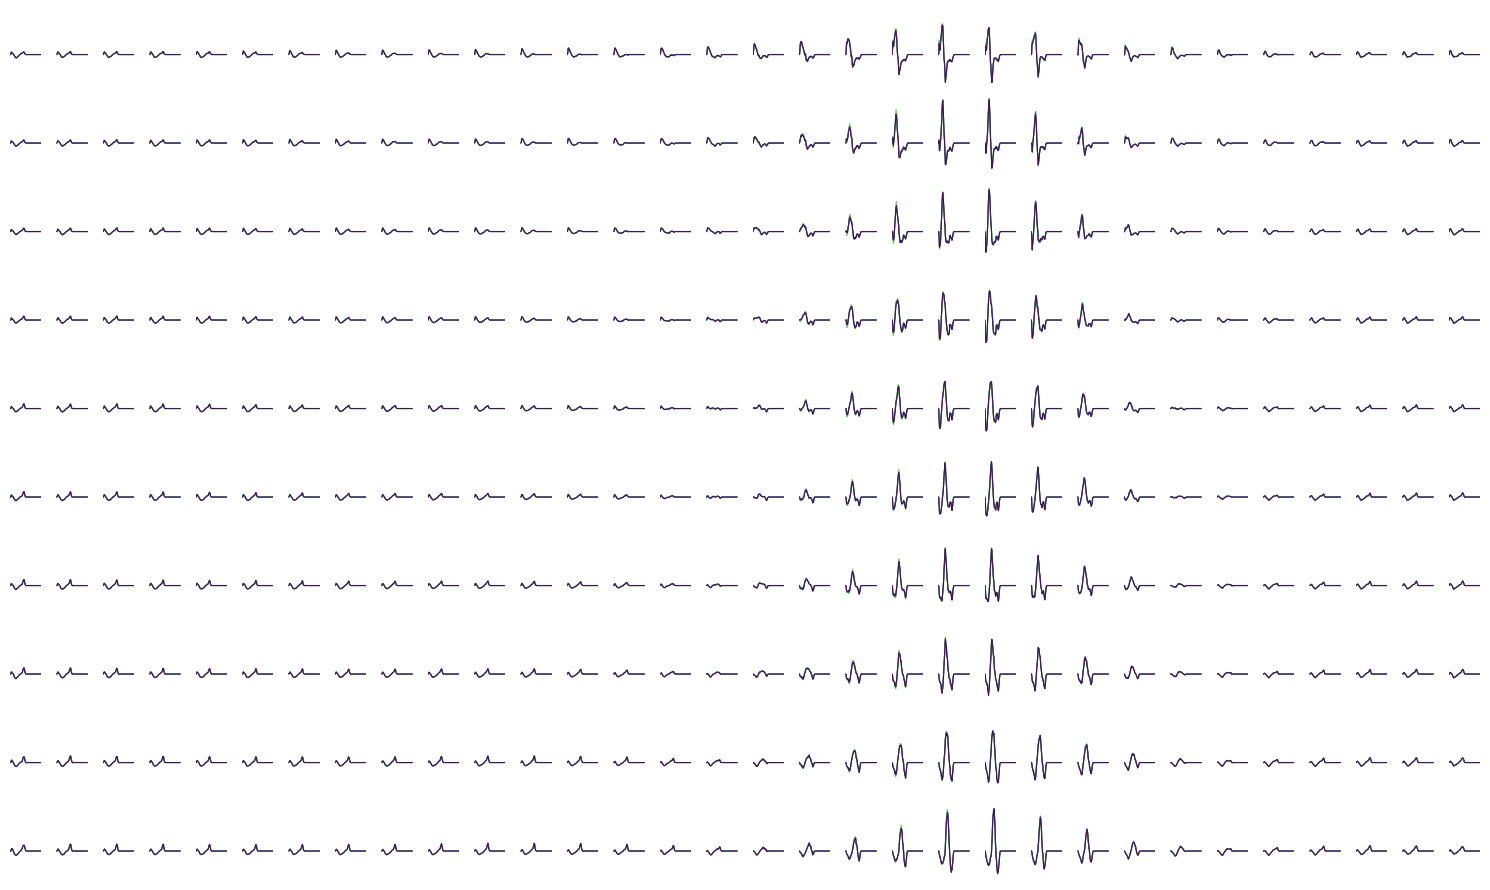

In [149]:
from easydict import EasyDict as edict
# torch.Size([5, 256, 6, 2, 4])
zi = torch.randn(num_mus, cfg.Model.Generator.Latent)
sim = generator.sample(num_mus, cond.float(), cond.device)
print(sim.shape)
sim = sim.permute(0, 2, 3, 1).cpu().detach().numpy()
sim_muaps = np.array([sim])
plot_muaps(sim_muaps, '.')


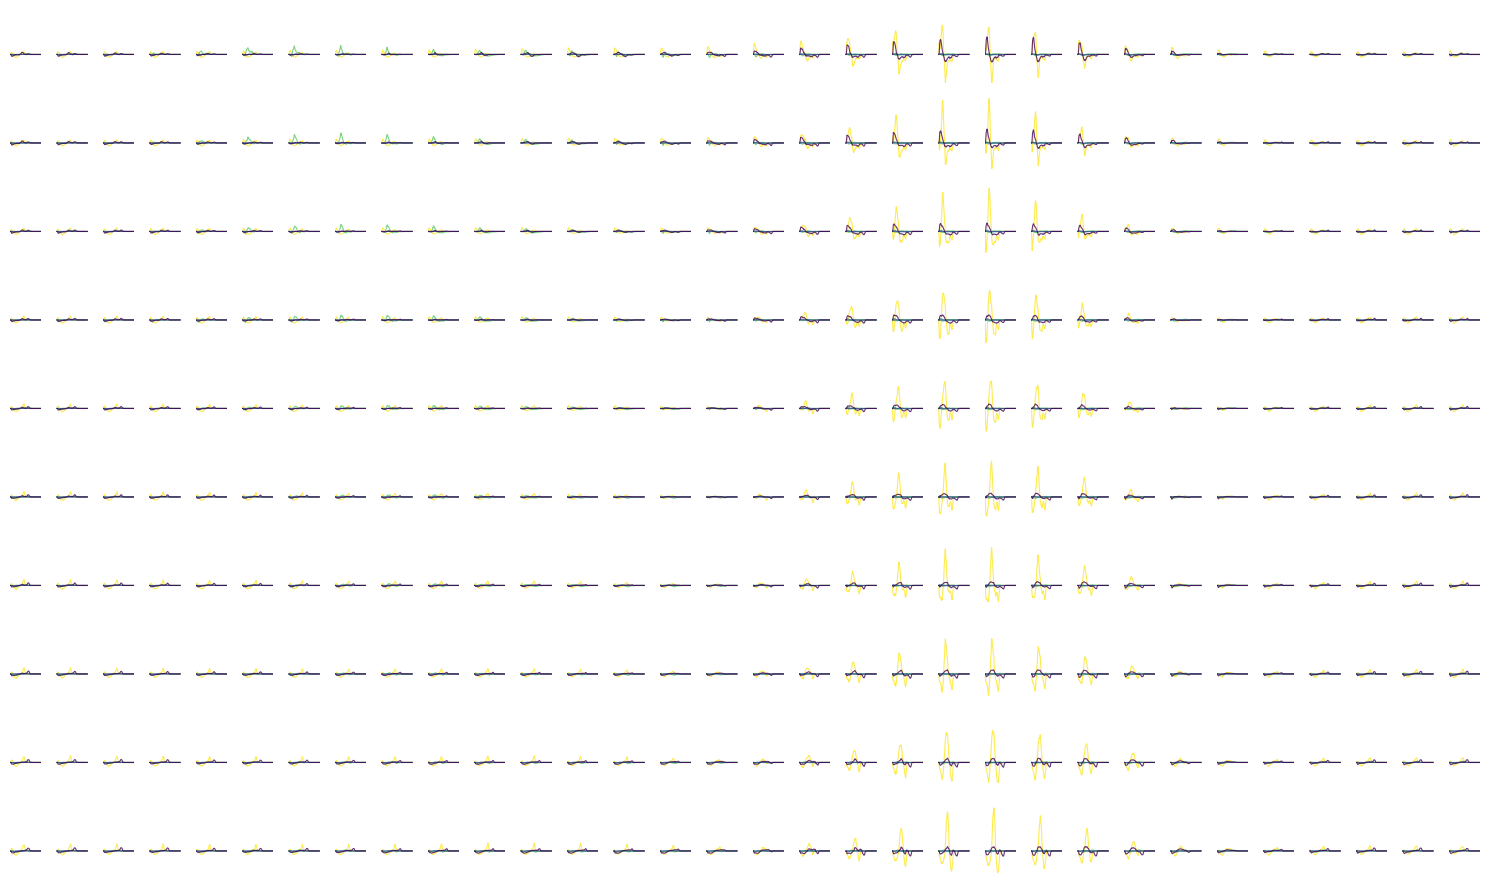

In [22]:
zi = torch.randn(num_mus, cfg.Model.Generator.Latent)
sim = generator.sample(num_mus, cond.float(), cond.device, zi)
sim = sim.permute(0, 2, 3, 1).cpu().detach().numpy()
sim_muaps = np.array([sim])
plot_muaps(sim_muaps, '.')

In [23]:
sim_muaps.shape

(1, 5, 10, 32, 96)

In [25]:
cond

tensor([[0.8179, 0.6703, 0.8239, 0.7876, 0.8606, 0.6306],
        [0.6810, 0.6745, 0.6629, 0.6083, 0.5548, 0.7276],
        [0.5968, 0.9446, 0.7957, 0.7654, 0.6251, 0.8807],
        [0.5063, 0.8822, 0.8970, 0.7386, 0.8916, 0.8816],
        [0.7706, 0.9259, 0.8232, 0.9372, 0.5522, 0.6368]])

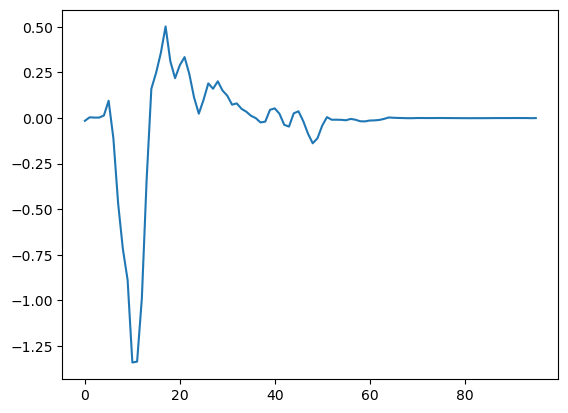

In [73]:
plt.plot(sim_muaps[0][0][0][0])